In [78]:
# Imports
import os
import h5py
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Global variables
train_dir = 'svhn_large_data/train'
test_dir = 'svhn_large_data/test'
extra_dir = 'svhn_large_data/extra'

In [2]:
# Extract image metadata
def extract_metadata(dr):
    metadata = {}
    fl = h5py.File(dr + '/digitStruct.mat')
    
    for i in xrange(len([x for x in os.listdir(dr) if x.split('.')[1] == 'png'])):        
        name = fl['digitStruct']['name'][i][0]
        bbox = fl['digitStruct']['bbox'][i][0]
        image_metadata = []
    
        if len(fl[bbox]['label']) == 1:    
            digit_metadata = {}
            digit_metadata['height'] = fl[bbox]['height'][0][0]
            digit_metadata['width'] = fl[bbox]['width'][0][0]
            digit_metadata['top'] = fl[bbox]['top'][0][0]
            digit_metadata['left'] = fl[bbox]['left'][0][0]
            digit_metadata['label'] = fl[bbox]['label'][0][0]
            image_metadata.append(digit_metadata)                    
        else:
            for j in xrange(len(fl[bbox]['label'])):
                digit_metadata = {}
                digit_metadata['height'] = [x for x in fl[fl[bbox]['height'][j][0]]][0][0]
                digit_metadata['width'] = [x for x in fl[fl[bbox]['width'][j][0]]][0][0]
                digit_metadata['top'] = [x for x in fl[fl[bbox]['top'][j][0]]][0][0]
                digit_metadata['left'] = [x for x in fl[fl[bbox]['left'][j][0]]][0][0]
                digit_metadata['label'] = [x for x in fl[fl[bbox]['label'][j][0]]][0][0]
                image_metadata.append(digit_metadata)                    
        
        metadata[''.join(chr(c) for c in fl[name][:])] = image_metadata
    
    return metadata

train_metadata = extract_metadata(train_dir)
test_metadata = extract_metadata(test_dir)
# extra_metadata = extract_metadata(extra_dir)

In [3]:
# 29930.png in the training set is the only image with more than 5 digits, so we will treat it as an outlier an remove it
display.display(display.Image(train_dir + '/' + str(29930) + '.png'))
if '29930.png' in train_metadata:
    del train_metadata['29930.png']


1.png digit 0: height = 219.0 wigth = 81.0 top = 77.0 left = 246.0 label = 1.0
1.png digit 1: height = 219.0 wigth = 96.0 top = 81.0 left = 323.0 label = 9.0


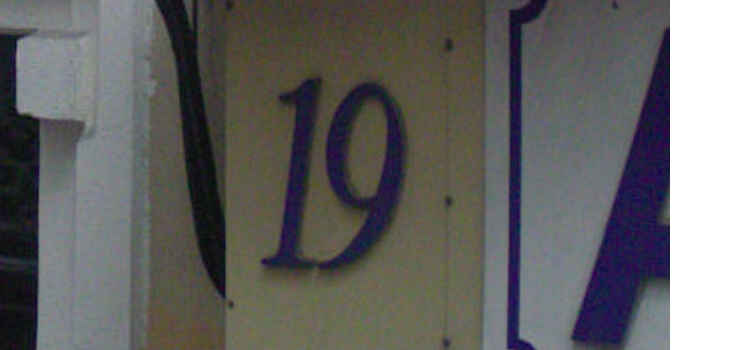


2.png digit 0: height = 32.0 wigth = 23.0 top = 29.0 left = 77.0 label = 2.0
2.png digit 1: height = 32.0 wigth = 26.0 top = 25.0 left = 98.0 label = 3.0


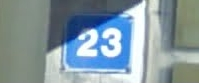

In [4]:
# look at a few images
for i in xrange(1, 3):
    s = '\n'
    for j in xrange(len(train_metadata[str(i) + '.png'])):
        s += str(i) + '.png digit ' + str(j) + ':'
        s += ' height = ' + str(train_metadata[str(i) + '.png'][j]['height'])
        s += ' wigth = ' + str(train_metadata[str(i) + '.png'][j]['width'])
        s += ' top = ' + str(train_metadata[str(i) + '.png'][j]['top'])
        s += ' left = ' + str(train_metadata[str(i) + '.png'][j]['left'])
        s += ' label = ' + str(train_metadata[str(i) + '.png'][j]['label'])
        s += '\n' if j != len(train_metadata[str(i) + '.png']) - 1 else ''
    print(s)
    display.display(display.Image(train_dir + '/' + str(i) + '.png'))

In [5]:
# Open images, convert to grayscale, resize, convert to numpy, and normalize
# Create labels
train_num = 25000
img_size = 64
channels_num = 1
labels_num = 11
digits_num = 5

train_X = np.ndarray((train_num, img_size, img_size, channels_num)).astype(np.float32)
train_y = np.ndarray((train_num, digits_num, labels_num))
valid_X = np.ndarray((len(train_metadata) - train_num, img_size, img_size, channels_num)).astype(np.float32)
valid_y = np.ndarray((len(train_metadata) - train_num, digits_num, labels_num))
test_X = np.ndarray((len(test_metadata), img_size, img_size, channels_num)).astype(np.float32)
test_y = np.ndarray((len(test_metadata), digits_num, labels_num))

# Training
for i in xrange(1, len(train_X) + 1):
    img = Image.open(train_dir + '/' + str(i) + '.png')
    img_gray = img.convert('L')
    img_resized = img_gray.resize((img_size, img_size), Image.ANTIALIAS)
    img_np = np.array(img_resized)
    img_normal = (img_np - (255.0 / 2.0)) / 255.0
    img_reshaped = img_normal.reshape((img_size, img_size, channels_num))
    train_X[i - 1,:,:,:] = img_reshaped
    
    for j in xrange(digits_num):
        if j < len(train_metadata[str(i) + '.png']):
            label = train_metadata[str(i) + '.png'][j]['label']
            train_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            train_y[i - 1,j,:] = np.arange(labels_num) == 10
    
# Validation
for i in xrange(len(valid_X) + 1):
    if i != 4929:  # Account for outlier
        img = Image.open(train_dir + '/' + str(i + len(train_X) + 1) + '.png')
        img_gray = img.convert('L')
        img_resized = img_gray.resize((img_size, img_size), Image.ANTIALIAS)
        img_np = np.array(img_resized)
        img_normal = (img_np - (255.0 / 2.0)) / 255.0
        img_reshaped = img_normal.reshape((img_size, img_size, channels_num))
        valid_X[i if i < 4929 else i - 1,:,:,:] = img_reshaped

        for j in xrange(digits_num):
            if j < len(train_metadata[str(i + len(train_X) + 1) + '.png']):
                label = train_metadata[str(i + len(train_X) + 1) + '.png'][j]['label']
                index = i if i < 4929 else i - 1
                valid_y[index,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
            else:
                valid_y[index,j,:] = np.arange(labels_num) == 10

# Testing
for i in xrange(1, len(test_X) + 1):
    img = Image.open(test_dir + '/' + str(i) + '.png')
    img_gray = img.convert('L')
    img_resized = img_gray.resize((img_size, img_size), Image.ANTIALIAS)
    img_np = np.array(img_resized)
    img_normal = (img_np - (255.0 / 2.0)) / 255.0
    img_reshaped = img_normal.reshape((img_size, img_size, channels_num))
    test_X[i - 1,:,:,:] = img_reshaped
    
    for j in xrange(digits_num):
        if j < len(test_metadata[str(i) + '.png']):
            label = test_metadata[str(i) + '.png'][j]['label']
            test_y[i - 1,j,:] = np.arange(labels_num) == (label if label != 10 else 0)
        else:
            test_y[i - 1,j,:] = np.arange(labels_num) == 10

Training data shape: (25000, 64, 64, 1)
Validation data shape: (8401, 64, 64, 1)
Testing data shape: (13068, 64, 64, 1)

1.png digit 0: height = 219.0 wigth = 81.0 top = 77.0 left = 246.0 label = 1.0
1.png digit 1: height = 219.0 wigth = 96.0 top = 81.0 left = 323.0 label = 9.0

2.png digit 0: height = 32.0 wigth = 23.0 top = 29.0 left = 77.0 label = 2.0
2.png digit 1: height = 32.0 wigth = 26.0 top = 25.0 left = 98.0 label = 3.0


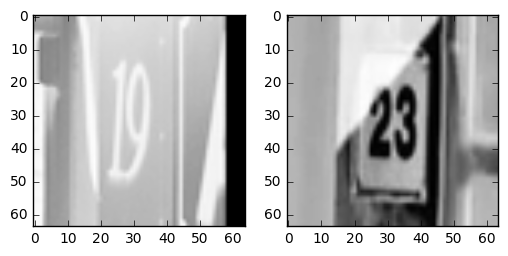

In [6]:
# Make sure we preprocessed correctly
print('Training data shape: ' + str(train_X.shape))
print('Validation data shape: ' + str(valid_X.shape))
print('Testing data shape: ' + str(test_X.shape))

for i in xrange(1, 3):
    s = '\n'
    for j in xrange(len(train_metadata[str(i) + '.png'])):
        s += str(i) + '.png digit ' + str(j) + ':'
        s += ' height = ' + str(train_metadata[str(i) + '.png'][j]['height'])
        s += ' wigth = ' + str(train_metadata[str(i) + '.png'][j]['width'])
        s += ' top = ' + str(train_metadata[str(i) + '.png'][j]['top'])
        s += ' left = ' + str(train_metadata[str(i) + '.png'][j]['left'])
        s += ' label = ' + str(train_metadata[str(i) + '.png'][j]['label'])
        s += '\n' if j != len(train_metadata[str(i) + '.png']) - 1 else ''
    print(s)
    
%matplotlib inline  
_, (sp1, sp2) = plt.subplots(1, 2)
sp1.imshow(train_X[0].reshape(img_size, img_size), cmap=plt.cm.Greys);
sp2.imshow(train_X[1].reshape(img_size, img_size), cmap=plt.cm.Greys);

In [142]:
# Define our performance metric
def accuracy(preds, labels):
    for i in xrange(5):
    #     print(train[i])
    #     print(train_y[i])
        print(np.argmax(preds[i], 1))
        print(np.argmax(labels[i], 1))
        print('')
    return 100 * np.sum(np.argmax(preds, 2) == np.argmax(labels, 2)) / (preds.shape[0] * preds.shape[1])

In [141]:
# """ LINEAR NEURAL NETWORK """

# # Variables
# steps_num = 1001
# subset = 100
# flat_data_size = img_size * img_size * channels_num
# train_accuracies = []
# valid_accuracies = []
# losses = []

# # Graph
# graph = tf.Graph()
# with graph.as_default():
#     # Reshape data
#     train_X_flat = train_X.reshape((-1, flat_data_size))
    
#     # Data
#     train_X_tf = tf.placeholder(tf.float32, (subset, flat_data_size))
#     train_y_tf = tf.placeholder(tf.float32, (subset, digits_num, labels_num))

#     # Weights
#     weights_1 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
#     weights_2 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
#     weights_3 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
#     weights_4 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))
#     weights_5 = tf.Variable(tf.truncated_normal((img_size * img_size, labels_num), stddev=0.1))

#     # Biases
#     bias_1 = tf.Variable(tf.zeros(labels_num))
#     bias_2 = tf.Variable(tf.zeros(labels_num))
#     bias_3 = tf.Variable(tf.zeros(labels_num))
#     bias_4 = tf.Variable(tf.zeros(labels_num))
#     bias_5 = tf.Variable(tf.zeros(labels_num))

#     # Model
#     def model(data):
#         logits_1 = tf.matmul(data, weights_1) + bias_1
#         logits_2 = tf.matmul(data, weights_2) + bias_2
#         logits_3 = tf.matmul(data, weights_3) + bias_3
#         logits_4 = tf.matmul(data, weights_4) + bias_4
#         logits_5 = tf.matmul(data, weights_5) + bias_5
#         return (logits_1, logits_2, logits_3, logits_4, logits_5)

#     # Logits
#     (train_logits_1, train_logits_2, train_logits_3, train_logits_4, train_logits_5) = model(train_X_tf)
    
#     # Loss
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits_1, train_y_tf[:,0,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_logits_2, train_y_tf[:,1,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_logits_3, train_y_tf[:,2,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_logits_4, train_y_tf[:,3,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_logits_5, train_y_tf[:,4,:]))

#     # Optimizer
#     optimizer = tf.train.AdamOptimizer().minimize(loss)

#     # Predictions
#     train_preds = tf.pack((tf.nn.softmax(train_logits_1), 
#                           tf.nn.softmax(train_logits_2), 
#                           tf.nn.softmax(train_logits_3), 
#                           tf.nn.softmax(train_logits_4), 
#                           tf.nn.softmax(train_logits_5)), 1)
    
# # Session
# with tf.Session(graph=graph) as session:
#     tf.initialize_all_variables().run()
    
#     # Train
#     for i in xrange(steps_num):
#         batch_X = train_X_flat[:subset,:]
#         batch_y = train_y[:subset,:]
#         feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
#         _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)
        
        
#         train = preds
        
        
#         # Report training accuracy        
#         if i % 100 == 0:
#             train_accuracy = accuracy(preds, batch_y)
#             train_accuracies.append(train_accuracy)
#             losses.append(l)
#             print('Step %d: Loss = %.2f, Training accuracy = %.2f%%\n' % (i, l, train_accuracy))
    
# # Plot training graph to access under/overfitting
# l, = plt.plot(losses, label='Loss')
# ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
# plt.xlabel('Training Steps (hundreds)')
# plt.ylim(0, 100)
# plt.xlim(0, 10)
# plt.title('Overfitting')
# plt.legend(handles=[ta, l])
# plt.show()

[ 2  3 10 10 10]
[ 1  2  4 10 10]

[ 2  3 10 10 10]
[ 2  7 10 10 10]

[ 2  0 10 10 10]
[ 3  3 10 10 10]

[1 1 7 3 1]
[ 1  1 10 10 10]

[ 2 10 10 10 10]
[ 1  1 10 10 10]

Step 1000: Loss = 7.71, Training accuracy = 60.62%, Validation accuracy = 41.65%

[ 2 10 10 10 10]
[ 3 10 10 10 10]

[ 1  8 10 10 10]
[ 1  1 10 10 10]

[ 1 10 10 10 10]
[ 9  7  3 10 10]

[ 2  2 10 10 10]
[ 2  8 10 10 10]

[ 1 10  0 10 10]
[ 3  1  2 10 10]

Step 2000: Loss = 6.42, Training accuracy = 66.88%, Validation accuracy = 41.65%

[ 1  8 10 10 10]
[ 1  4 10 10 10]

[ 3  8 10 10 10]
[ 3  3  6 10 10]

[ 1  1 10 10 10]
[ 5  0 10 10 10]

[ 3  2 10 10 10]
[ 5  2 10 10 10]

[ 2  3 10 10 10]
[ 9 10 10 10 10]

Step 3000: Loss = 5.10, Training accuracy = 71.25%, Validation accuracy = 41.65%

[ 7  4 10 10 10]
[ 7  4 10 10 10]

[ 4  0 10 10 10]
[ 4  5 10 10 10]

[ 1  1 10 10 10]
[ 6  0 10 10 10]

[ 6  1 10 10 10]
[ 3 10 10 10 10]

[ 1  1 10 10 10]
[ 1  7 10 10 10]

Step 4000: Loss = 4.91, Training accuracy = 71.88%, Validat

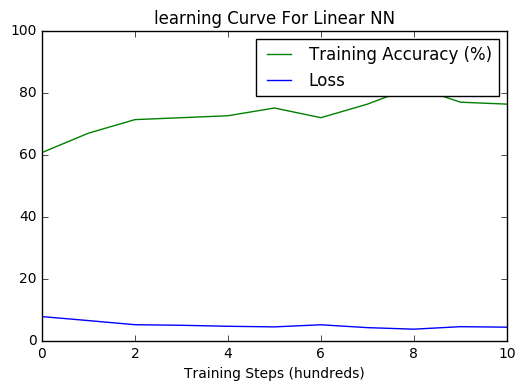

In [155]:
""" LINEAR NEURAL NETWORK """

# Variables
batch_size = 32
reg_constant = 0.001
steps_num = 20001
steps_num_small = 251
subset = 100
flat_data_size = img_size * img_size * channels_num
train_accuracies = []
valid_accuracies = []
losses = []

# Graph
graph = tf.Graph()
with graph.as_default():
    # Data
    train_X_flat = train_X.reshape((-1, flat_data_size))
    valid_X_flat = valid_X.reshape((-1, flat_data_size))
    test_X_flat = test_X.reshape((-1, flat_data_size))
    train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size))
    train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
    valid_X_tf = tf.constant(valid_X_flat)
    test_X_tf = tf.constant(test_X_flat)

    # Weights
    weights_1 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_2 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_3 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_4 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))
    weights_5 = tf.Variable(tf.random_normal((img_size * img_size, labels_num), stddev=0.1))

    # Biases
    bias_1 = tf.Variable(tf.zeros(labels_num))
    bias_2 = tf.Variable(tf.zeros(labels_num))
    bias_3 = tf.Variable(tf.zeros(labels_num))
    bias_4 = tf.Variable(tf.zeros(labels_num))
    bias_5 = tf.Variable(tf.zeros(labels_num))

    # Model
    def model(data):
        logits_1 = tf.matmul(data, weights_1) + bias_1
        logits_2 = tf.matmul(data, weights_2) + bias_2
        logits_3 = tf.matmul(data, weights_3) + bias_3
        logits_4 = tf.matmul(data, weights_4) + bias_4
        logits_5 = tf.matmul(data, weights_5) + bias_5
        return (logits_1, logits_2, logits_3, logits_4, logits_5)

    # Logits
    (train_logits_1, train_logits_2, train_logits_3, train_logits_4, train_logits_5) = model(train_X_tf)
    (valid_logits_1, valid_logits_2, valid_logits_3, valid_logits_4, valid_logits_5) = model(valid_X_tf)
    (test_logits_1, test_logits_2, test_logits_3, test_logits_4, test_logits_5) = model(test_X_tf)
    
    # Loss
    regularization = reg_constant * (tf.nn.l2_loss(weights_1) + 
                                     tf.nn.l2_loss(weights_2) + 
                                     tf.nn.l2_loss(weights_3) + 
                                     tf.nn.l2_loss(weights_4) + 
                                     tf.nn.l2_loss(weights_5))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits_1, train_y_tf[:,0,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_2, train_y_tf[:,1,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_3, train_y_tf[:,2,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_4, train_y_tf[:,3,:]) + 
                          tf.nn.softmax_cross_entropy_with_logits(train_logits_5, train_y_tf[:,4,:]) + 
                          regularization)

    # Optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Predictions
    train_preds = tf.pack((tf.nn.softmax(train_logits_1), 
                          tf.nn.softmax(train_logits_2), 
                          tf.nn.softmax(train_logits_3), 
                          tf.nn.softmax(train_logits_4), 
                          tf.nn.softmax(train_logits_5)), 1)

    valid_preds = tf.pack((tf.nn.softmax(valid_logits_1), 
                          tf.nn.softmax(valid_logits_2), 
                          tf.nn.softmax(valid_logits_3), 
                          tf.nn.softmax(valid_logits_4), 
                          tf.nn.softmax(valid_logits_5)), 1)

    test_preds = tf.pack((tf.nn.softmax(test_logits_1), 
                         tf.nn.softmax(test_logits_2), 
                         tf.nn.softmax(test_logits_3), 
                         tf.nn.softmax(test_logits_4), 
                         tf.nn.softmax(test_logits_5)), 1)

# Session
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    for i in xrange(steps_num):
        # Get batch data and labels
        batch_start = batch_size * i % (2000 - batch_size)
        batch_end = batch_start + batch_size
        batch_X = train_X_flat[batch_start:batch_end,:]
        batch_y = train_y[batch_start:batch_end,:]
#         batch_X = train_X_flat[:32,:]
#         batch_y = train_y[:32,:]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
        _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)
        
        
        train = preds
        
        
        # Report validation accuracy
        if i % 1000 == 0 and i != 0:
            train_accuracy = accuracy(preds, batch_y)
#             valid_accuracy = accuracy(valid_preds.eval(), valid_y)
            train_accuracies.append(train_accuracy)
#             valid_accuracies.append(valid_accuracy)
            losses.append(l)
            print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
                  (i, l, train_accuracy, valid_accuracy))
    
#     print('Test set accuracy = %.2f%%' % accuracy(test_preds.eval(), test_y))
        
# Plot training graph to access performance
l, = plt.plot(losses, label='Loss')
ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
# va, = plt.plot(valid_accuracies, label='Validation Accuracy (%)')
plt.xlabel('Training Steps (hundreds)')
plt.ylim(0, 100)
plt.xlim(0, 10)
plt.title('learning Curve For Linear NN')
plt.legend(handles=[ta, l])
plt.show()

Step 0: Loss = 142.30, Training accuracy = 8.75%, Validation accuracy = 43.83%

Step 100: Loss = 99.76, Training accuracy = 64.38%, Validation accuracy = 59.86%

Step 200: Loss = 81.61, Training accuracy = 55.62%, Validation accuracy = 60.92%

Step 300: Loss = 63.93, Training accuracy = 61.25%, Validation accuracy = 60.87%

Step 400: Loss = 48.37, Training accuracy = 61.88%, Validation accuracy = 61.20%

Step 500: Loss = 38.07, Training accuracy = 60.62%, Validation accuracy = 61.28%

Step 600: Loss = 29.20, Training accuracy = 60.62%, Validation accuracy = 61.40%

Step 700: Loss = 22.71, Training accuracy = 60.00%, Validation accuracy = 61.40%

Step 800: Loss = 18.25, Training accuracy = 56.25%, Validation accuracy = 61.41%

Step 900: Loss = 13.76, Training accuracy = 65.62%, Validation accuracy = 61.39%

Step 1000: Loss = 11.92, Training accuracy = 63.12%, Validation accuracy = 61.37%

Test set accuracy = 65.70%


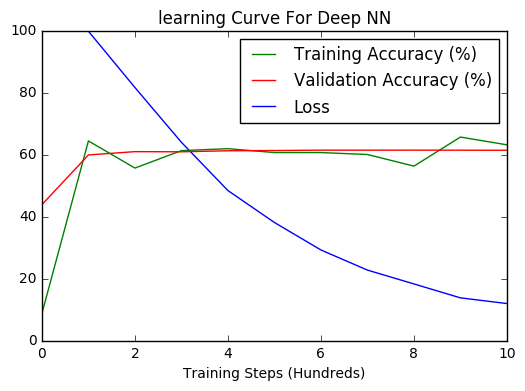

In [10]:
# """ DEEP NEURAL NETWORK """

# # Hyperparameters
# batch_size = 32
# reg_constant = 0.001
# dropout_rate = 0.5
# steps_num = 1001
# flat_data_size = img_size * img_size * channels_num
# hidden_first_nodes = 1024
# hidden_second_nodes = 128
# train_accuracies = []
# valid_accuracies = []
# losses = []

# # Graph
# graph = tf.Graph()
# with graph.as_default():
#     # Data
#     train_X_flat = train_X.reshape((-1, flat_data_size))
#     valid_X_flat = valid_X.reshape((-1, flat_data_size))
#     test_X_flat = test_X.reshape((-1, flat_data_size))
#     train_X_tf = tf.placeholder(tf.float32, (batch_size, flat_data_size))
#     train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
#     valid_X_tf = tf.constant(valid_X_flat)
#     test_X_tf = tf.constant(test_X_flat)

#     # First hidden weights
#     weights_hidden_first_1 = tf.Variable(tf.random_normal((flat_data_size, hidden_first_nodes), stddev=0.1))
#     weights_hidden_first_2 = tf.Variable(tf.random_normal((flat_data_size, hidden_first_nodes), stddev=0.1))
#     weights_hidden_first_3 = tf.Variable(tf.random_normal((flat_data_size, hidden_first_nodes), stddev=0.1))
#     weights_hidden_first_4 = tf.Variable(tf.random_normal((flat_data_size, hidden_first_nodes), stddev=0.1))
#     weights_hidden_first_5 = tf.Variable(tf.random_normal((flat_data_size, hidden_first_nodes), stddev=0.1))

#     # First hidden biases
#     biases_hidden_first_1 = tf.Variable(tf.zeros(hidden_first_nodes))
#     biases_hidden_first_2 = tf.Variable(tf.zeros(hidden_first_nodes))
#     biases_hidden_first_3 = tf.Variable(tf.zeros(hidden_first_nodes))
#     biases_hidden_first_4 = tf.Variable(tf.zeros(hidden_first_nodes))
#     biases_hidden_first_5 = tf.Variable(tf.zeros(hidden_first_nodes))
    
#     # Second hidden weights
#     weights_hidden_second_1 = tf.Variable(tf.random_normal((hidden_first_nodes, hidden_second_nodes), stddev=0.1))
#     weights_hidden_second_2 = tf.Variable(tf.random_normal((hidden_first_nodes, hidden_second_nodes), stddev=0.1))
#     weights_hidden_second_3 = tf.Variable(tf.random_normal((hidden_first_nodes, hidden_second_nodes), stddev=0.1))
#     weights_hidden_second_4 = tf.Variable(tf.random_normal((hidden_first_nodes, hidden_second_nodes), stddev=0.1))
#     weights_hidden_second_5 = tf.Variable(tf.random_normal((hidden_first_nodes, hidden_second_nodes), stddev=0.1))

#     # Second hidden biases
#     biases_hidden_second_1 = tf.Variable(tf.zeros(hidden_second_nodes))
#     biases_hidden_second_2 = tf.Variable(tf.zeros(hidden_second_nodes))
#     biases_hidden_second_3 = tf.Variable(tf.zeros(hidden_second_nodes))
#     biases_hidden_second_4 = tf.Variable(tf.zeros(hidden_second_nodes))
#     biases_hidden_second_5 = tf.Variable(tf.zeros(hidden_second_nodes))
    
#     # Output weights
#     weights_output_1 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
#     weights_output_2 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
#     weights_output_3 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
#     weights_output_4 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))
#     weights_output_5 = tf.Variable(tf.random_normal((hidden_second_nodes, labels_num), stddev=0.1))

#     # Output biases
#     biases_output_1 = tf.Variable(tf.zeros(labels_num))
#     biases_output_2 = tf.Variable(tf.zeros(labels_num))
#     biases_output_3 = tf.Variable(tf.zeros(labels_num))
#     biases_output_4 = tf.Variable(tf.zeros(labels_num))
#     biases_output_5 = tf.Variable(tf.zeros(labels_num)) 

#     # Model
#     def model(data):
#         # Compute first hidden layer
#         hidden_first_1 = tf.nn.relu(tf.matmul(data, weights_hidden_first_1) + biases_hidden_first_1)
#         hidden_first_2 = tf.nn.relu(tf.matmul(data, weights_hidden_first_2) + biases_hidden_first_2)
#         hidden_first_3 = tf.nn.relu(tf.matmul(data, weights_hidden_first_3) + biases_hidden_first_3)
#         hidden_first_4 = tf.nn.relu(tf.matmul(data, weights_hidden_first_4) + biases_hidden_first_4)
#         hidden_first_5 = tf.nn.relu(tf.matmul(data, weights_hidden_first_5) + biases_hidden_first_5)
                            
#         # Compute second hidden layer
#         hidden_second_1 = tf.nn.relu(tf.matmul(hidden_first_1, weights_hidden_second_1) + biases_hidden_second_1)
#         hidden_second_2 = tf.nn.relu(tf.matmul(hidden_first_2, weights_hidden_second_2) + biases_hidden_second_2)
#         hidden_second_3 = tf.nn.relu(tf.matmul(hidden_first_3, weights_hidden_second_3) + biases_hidden_second_3)
#         hidden_second_4 = tf.nn.relu(tf.matmul(hidden_first_4, weights_hidden_second_4) + biases_hidden_second_4)
#         hidden_second_5 = tf.nn.relu(tf.matmul(hidden_first_5, weights_hidden_second_5) + biases_hidden_second_5)
        
#         # Dropout regularization
#         hidden_second_1 = tf.nn.dropout(hidden_second_1, dropout_rate)
#         hidden_second_2 = tf.nn.dropout(hidden_second_2, dropout_rate)
#         hidden_second_3 = tf.nn.dropout(hidden_second_3, dropout_rate)
#         hidden_second_4 = tf.nn.dropout(hidden_second_4, dropout_rate)
#         hidden_second_5 = tf.nn.dropout(hidden_second_5, dropout_rate)
        
#         # Compute output layer
#         output_1 = tf.matmul(hidden_second_1, weights_output_1) + biases_output_1
#         output_2 = tf.matmul(hidden_second_2, weights_output_2) + biases_output_2
#         output_3 = tf.matmul(hidden_second_3, weights_output_3) + biases_output_3
#         output_4 = tf.matmul(hidden_second_4, weights_output_4) + biases_output_4
#         output_5 = tf.matmul(hidden_second_5, weights_output_5) + biases_output_5
    
#         # Return outputs
#         return (output_1, output_2, output_3, output_4, output_5)

#     # Logits
#     (train_output_1, train_output_2, train_output_3, train_output_4, train_output_5) = model(train_X_tf)
#     (valid_output_1, valid_output_2, valid_output_3, valid_output_4, valid_output_5) = model(valid_X_tf)
#     (test_output_1, test_output_2, test_output_3, test_output_4, test_output_5) = model(test_X_tf)
    
#     # L2 regularization
#     regularization = reg_constant * (tf.nn.l2_loss(weights_hidden_first_1) + 
#                                      tf.nn.l2_loss(weights_hidden_first_2) + 
#                                      tf.nn.l2_loss(weights_hidden_first_3) + 
#                                      tf.nn.l2_loss(weights_hidden_first_4) + 
#                                      tf.nn.l2_loss(weights_hidden_first_5) + 
#                                      tf.nn.l2_loss(weights_hidden_second_1) + 
#                                      tf.nn.l2_loss(weights_hidden_second_2) + 
#                                      tf.nn.l2_loss(weights_hidden_second_3) + 
#                                      tf.nn.l2_loss(weights_hidden_second_4) + 
#                                      tf.nn.l2_loss(weights_hidden_second_5) + 
#                                      tf.nn.l2_loss(weights_output_1) + 
#                                      tf.nn.l2_loss(weights_output_2) + 
#                                      tf.nn.l2_loss(weights_output_3) + 
#                                      tf.nn.l2_loss(weights_output_4) + 
#                                      tf.nn.l2_loss(weights_output_5))
    
#     # Loss
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
#                           regularization)

#     # Optimizer
#     optimizer = tf.train.AdamOptimizer().minimize(loss)

#     # Predictions
#     train_preds = tf.pack((tf.nn.softmax(train_output_1), 
#                           tf.nn.softmax(train_output_2), 
#                           tf.nn.softmax(train_output_3), 
#                           tf.nn.softmax(train_output_4), 
#                           tf.nn.softmax(train_output_5)), 1)

#     valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
#                           tf.nn.softmax(valid_output_2), 
#                           tf.nn.softmax(valid_output_3), 
#                           tf.nn.softmax(valid_output_4), 
#                           tf.nn.softmax(valid_output_5)), 1)

#     test_preds = tf.pack((tf.nn.softmax(test_output_1), 
#                          tf.nn.softmax(test_output_2), 
#                          tf.nn.softmax(test_output_3), 
#                          tf.nn.softmax(test_output_4), 
#                          tf.nn.softmax(test_output_5)), 1)

# # Session
# with tf.Session(graph=graph) as session:
#     tf.initialize_all_variables().run()
    
#     # Train
#     for i in xrange(steps_num):
#         batch_start = batch_size * i % (train_y.shape[0] - batch_size)
#         batch_end = batch_start + batch_size
#         batch_X = train_X_flat[batch_start:batch_end,:]
#         batch_y = train_y[batch_start:batch_end,:]
#         feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
#         _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        
        
#         # Report validation accuracy
#         if i % 100 == 0:
#             train_accuracy = accuracy(preds, batch_y)
#             valid_accuracy = accuracy(valid_preds.eval(), valid_y)
#             train_accuracies.append(train_accuracy)
#             valid_accuracies.append(valid_accuracy)
#             losses.append(l)

#             print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
#                   (i, l, train_accuracy, valid_accuracy))
        
#     print('Test set accuracy = %.2f%%' % accuracy(test_preds.eval(), test_y))
        
# # Plot training graph to access performance
# l, = plt.plot(losses, label='Loss')
# ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
# va, = plt.plot(valid_accuracies, label='Validation Accuracy (%)')
# plt.xlabel('Training Steps (Hundreds)')
# plt.ylim(0, 100)
# plt.xlim(0, 10)
# plt.title('learning Curve For Deep NN')
# plt.legend(handles=[ta, va, l])
# plt.show()

Step 0: Loss = 235.58, Training accuracy = 5.31%, Validation accuracy = 58.69%

Step 100: Loss = 94.96, Training accuracy = 60.00%, Validation accuracy = 61.32%

Step 200: Loss = 64.40, Training accuracy = 65.00%, Validation accuracy = 61.30%

Step 300: Loss = 48.81, Training accuracy = 59.69%, Validation accuracy = 61.33%

Step 400: Loss = 37.97, Training accuracy = 65.00%, Validation accuracy = 61.31%

Step 500: Loss = 30.69, Training accuracy = 62.19%, Validation accuracy = 61.38%

Step 600: Loss = 25.36, Training accuracy = 61.56%, Validation accuracy = 61.31%

Step 700: Loss = 20.78, Training accuracy = 62.50%, Validation accuracy = 61.35%

Step 800: Loss = 17.99, Training accuracy = 59.06%, Validation accuracy = 61.36%

Step 900: Loss = 15.12, Training accuracy = 61.88%, Validation accuracy = 61.57%

Step 1000: Loss = 13.18, Training accuracy = 59.38%, Validation accuracy = 62.39%

Test set accuracy = 65.42%


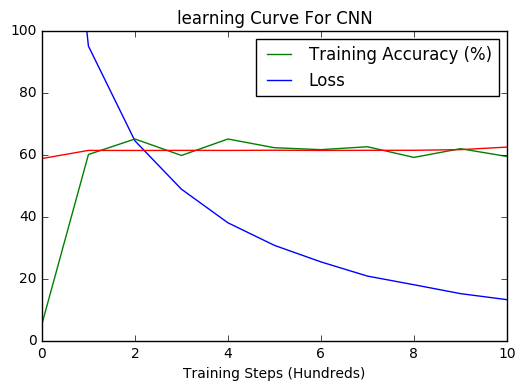

Training and evaluation took 43 minutes


In [80]:
# """ CONVOLUTIONAL NEURAL NETWORK """

# start = time.time()

# # Hyperparameters
# steps_num = 1001
# batch_size = 64
# patch_size = 5
# conv_depth_1 = 32
# conv_depth_2 = 64
# full_nodes = 512
# reg_constant = 0.001
# dropout_rate = 0.5
# train_accuracies = []
# valid_accuracies = []
# losses = []
# conv_stride = 1
# pool_window_size = [1, 2, 2, 1]
# pool_stride = [1, 2, 2, 1]
# padding = 'SAME'

# # Helper functions
# def create_weight(shape):
#     return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

# def create_bias(shape):
#     return tf.Variable(tf.constant(0.1, shape=shape))

# def create_conv_layer(data, weights):
#     return tf.nn.conv2d(data, weights, [1, conv_stride, conv_stride, 1], padding)

# def create_pool_layer(data):
#     return tf.nn.max_pool(data, pool_window_size, pool_stride, padding)

# def get_conv_shape(data_shape, weights_shape):
#     if padding == 'VALID':
#         new_height = int(np.ceil((data_shape[1] - weights_shape[0] + 1) / conv_stride))
#         new_width = int(np.ceil((data_shape[2] - weights_shape[1] + 1) / conv_stride))
#     else:
#         new_height = int(np.ceil(data_shape[1] / conv_stride))
#         new_width = int(np.ceil(data_shape[2] / conv_stride))
#     return (data_shape[0], new_height, new_width, weights_shape[3])

# def get_pool_shape(data_shape):
#     new_height = int(np.ceil(data_shape[1] / pool_stride[1]))
#     new_width = int(np.ceil(data_shape[2] / pool_stride[2]))
#     return (data_shape[0], new_height, new_width, data_shape[3])

# # Graph
# graph = tf.Graph()
# with graph.as_default():
    
#     # Data (don't flatten as we did before)
#     train_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
#     train_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
#     valid_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
#     valid_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))
#     test_X_tf = tf.placeholder(tf.float32, (batch_size, img_size, img_size, channels_num))
#     test_y_tf = tf.placeholder(tf.float32, (batch_size, digits_num, labels_num))

#     # First convolution layer weights
#     weights_conv_first_1 = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
#     weights_conv_first_2 = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
#     weights_conv_first_3 = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
#     weights_conv_first_4 = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
#     weights_conv_first_5 = create_weight((patch_size, patch_size, channels_num, conv_depth_1))
        
#     # First convolution layer biases
#     biases_conv_first_1 = create_bias((conv_depth_1,))
#     biases_conv_first_2 = create_bias((conv_depth_1,))
#     biases_conv_first_3 = create_bias((conv_depth_1,))
#     biases_conv_first_4 = create_bias((conv_depth_1,))
#     biases_conv_first_5 = create_bias((conv_depth_1,))

#     # Second convolution layer weights
#     weights_conv_second_1 = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))
#     weights_conv_second_2 = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))
#     weights_conv_second_3 = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))
#     weights_conv_second_4 = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))
#     weights_conv_second_5 = create_weight((patch_size, patch_size, conv_depth_1, conv_depth_2))

#     # Second convolution layer biases
#     biases_conv_second_1 = create_bias((conv_depth_2,))
#     biases_conv_second_2 = create_bias((conv_depth_2,))
#     biases_conv_second_3 = create_bias((conv_depth_2,))
#     biases_conv_second_4 = create_bias((conv_depth_2,))
#     biases_conv_second_5 = create_bias((conv_depth_2,))

#     # Calculate final pooled layer shape
#     conv_first_shape = get_conv_shape(train_X_tf.get_shape().as_list(), weights_conv_first_1.get_shape().as_list())
#     pool_first_shape = get_pool_shape(conv_first_shape)
#     conv_second_shape = get_conv_shape(pool_first_shape, weights_conv_second_1.get_shape().as_list())
#     pool_second_shape = get_pool_shape(conv_second_shape)
#     final_pooled_flat = pool_second_shape[1] * pool_second_shape[2] * pool_second_shape[3]
        
#     # Fully connected layer weights   
#     weights_full_1 = create_weight((final_pooled_flat, full_nodes))
#     weights_full_2 = create_weight((final_pooled_flat, full_nodes))
#     weights_full_3 = create_weight((final_pooled_flat, full_nodes))
#     weights_full_4 = create_weight((final_pooled_flat, full_nodes))
#     weights_full_5 = create_weight((final_pooled_flat, full_nodes))

#     # Fully connected layer biases
#     biases_full_1 = create_bias((full_nodes,))
#     biases_full_2 = create_bias((full_nodes,))
#     biases_full_3 = create_bias((full_nodes,))
#     biases_full_4 = create_bias((full_nodes,))
#     biases_full_5 = create_bias((full_nodes,))
    
#     # Output weights
#     weights_output_1 = create_weight((full_nodes, labels_num))
#     weights_output_2 = create_weight((full_nodes, labels_num))
#     weights_output_3 = create_weight((full_nodes, labels_num))
#     weights_output_4 = create_weight((full_nodes, labels_num))
#     weights_output_5 = create_weight((full_nodes, labels_num))

#     # Output biases
#     biases_output_1 = create_bias((labels_num,))
#     biases_output_2 = create_bias((labels_num,))
#     biases_output_3 = create_bias((labels_num,))
#     biases_output_4 = create_bias((labels_num,))
#     biases_output_5 = create_bias((labels_num,)) 
    
#     # Model
#     def model(data, dropout):
#         # First convolution layer
#         conv_first_1 = tf.nn.relu(create_conv_layer(data, weights_conv_first_1) + biases_conv_first_1)
#         conv_first_2 = tf.nn.relu(create_conv_layer(data, weights_conv_first_2) + biases_conv_first_2)
#         conv_first_3 = tf.nn.relu(create_conv_layer(data, weights_conv_first_3) + biases_conv_first_3)
#         conv_first_4 = tf.nn.relu(create_conv_layer(data, weights_conv_first_4) + biases_conv_first_4)
#         conv_first_5 = tf.nn.relu(create_conv_layer(data, weights_conv_first_5) + biases_conv_first_5)

#         # First pooling layer
#         pool_first_1 = create_pool_layer(conv_first_1)
#         pool_first_2 = create_pool_layer(conv_first_2)
#         pool_first_3 = create_pool_layer(conv_first_3)
#         pool_first_4 = create_pool_layer(conv_first_4)
#         pool_first_5 = create_pool_layer(conv_first_5)
        
#         # Second convolution layer
#         conv_second_1 = tf.nn.relu(create_conv_layer(pool_first_1, weights_conv_second_1) + biases_conv_second_1)
#         conv_second_2 = tf.nn.relu(create_conv_layer(pool_first_2, weights_conv_second_2) + biases_conv_second_2)
#         conv_second_3 = tf.nn.relu(create_conv_layer(pool_first_3, weights_conv_second_3) + biases_conv_second_3)
#         conv_second_4 = tf.nn.relu(create_conv_layer(pool_first_4, weights_conv_second_4) + biases_conv_second_4)
#         conv_second_5 = tf.nn.relu(create_conv_layer(pool_first_5, weights_conv_second_5) + biases_conv_second_5)

#         # Second pooling layer
#         pool_second_1 = create_pool_layer(conv_second_1)
#         pool_second_2 = create_pool_layer(conv_second_2)
#         pool_second_3 = create_pool_layer(conv_second_3)
#         pool_second_4 = create_pool_layer(conv_second_4)
#         pool_second_5 = create_pool_layer(conv_second_5)
        
#         # Reshape data
#         data_size = pool_second_1.get_shape().as_list()[0]
#         pool_second_1 = tf.reshape(pool_second_1, (data_size, final_pooled_flat))
#         pool_second_2 = tf.reshape(pool_second_2, (data_size, final_pooled_flat))
#         pool_second_3 = tf.reshape(pool_second_3, (data_size, final_pooled_flat))
#         pool_second_4 = tf.reshape(pool_second_4, (data_size, final_pooled_flat))
#         pool_second_5 = tf.reshape(pool_second_5, (data_size, final_pooled_flat))
        
#         # Fully connected layer
#         full_1 = tf.nn.relu(tf.matmul(pool_second_1, weights_full_1) + biases_full_1)
#         full_2 = tf.nn.relu(tf.matmul(pool_second_2, weights_full_2) + biases_full_2)
#         full_3 = tf.nn.relu(tf.matmul(pool_second_3, weights_full_3) + biases_full_3)
#         full_4 = tf.nn.relu(tf.matmul(pool_second_4, weights_full_4) + biases_full_4)
#         full_5 = tf.nn.relu(tf.matmul(pool_second_5, weights_full_5) + biases_full_5)
                
#         # Dropout regularization (only during training)
#         if dropout:
#             full_1 = tf.nn.dropout(full_1, dropout_rate)
#             full_2 = tf.nn.dropout(full_2, dropout_rate)
#             full_3 = tf.nn.dropout(full_3, dropout_rate)
#             full_4 = tf.nn.dropout(full_4, dropout_rate)
#             full_5 = tf.nn.dropout(full_5, dropout_rate)        

#         # Output layer
#         output_1 = tf.matmul(full_1, weights_output_1) + biases_output_1
#         output_2 = tf.matmul(full_2, weights_output_2) + biases_output_2
#         output_3 = tf.matmul(full_3, weights_output_3) + biases_output_3
#         output_4 = tf.matmul(full_4, weights_output_4) + biases_output_4
#         output_5 = tf.matmul(full_5, weights_output_5) + biases_output_5
    
#         # Return outputs
#         return (output_1, output_2, output_3, output_4, output_5)

#     # Logits
#     (train_output_1, train_output_2, train_output_3, train_output_4, train_output_5) = model(train_X_tf, True)
#     (valid_output_1, valid_output_2, valid_output_3, valid_output_4, valid_output_5) = model(valid_X_tf, False)
#     (test_output_1, test_output_2, test_output_3, test_output_4, test_output_5) = model(test_X_tf, False)
    
#     # L2 regularization (only on fully connected layers)
#     regularization = reg_constant * (tf.nn.l2_loss(weights_full_1) + 
#                                      tf.nn.l2_loss(weights_full_2) + 
#                                      tf.nn.l2_loss(weights_full_3) + 
#                                      tf.nn.l2_loss(weights_full_4) + 
#                                      tf.nn.l2_loss(weights_full_5) + 
#                                      tf.nn.l2_loss(weights_output_1) + 
#                                      tf.nn.l2_loss(weights_output_2) + 
#                                      tf.nn.l2_loss(weights_output_3) + 
#                                      tf.nn.l2_loss(weights_output_4) + 
#                                      tf.nn.l2_loss(weights_output_5))
    
#     # Loss
#     loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_output_1, train_y_tf[:,0,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_2, train_y_tf[:,1,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_3, train_y_tf[:,2,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_4, train_y_tf[:,3,:]) + 
#                           tf.nn.softmax_cross_entropy_with_logits(train_output_5, train_y_tf[:,4,:]) + 
#                           regularization)

#     # Optimizer
#     optimizer = tf.train.AdamOptimizer().minimize(loss)

#     # Predictions
#     train_preds = tf.pack((tf.nn.softmax(train_output_1), 
#                           tf.nn.softmax(train_output_2), 
#                           tf.nn.softmax(train_output_3), 
#                           tf.nn.softmax(train_output_4), 
#                           tf.nn.softmax(train_output_5)), 1)

#     valid_preds = tf.pack((tf.nn.softmax(valid_output_1), 
#                           tf.nn.softmax(valid_output_2), 
#                           tf.nn.softmax(valid_output_3), 
#                           tf.nn.softmax(valid_output_4), 
#                           tf.nn.softmax(valid_output_5)), 1)

#     test_preds = tf.pack((tf.nn.softmax(test_output_1), 
#                          tf.nn.softmax(test_output_2), 
#                          tf.nn.softmax(test_output_3), 
#                          tf.nn.softmax(test_output_4), 
#                          tf.nn.softmax(test_output_5)), 1)

# # Session
# with tf.Session(graph=graph) as session:
#     tf.initialize_all_variables().run()

#     # Train
#     for i in xrange(steps_num):
#         batch_start = batch_size * i % (train_y.shape[0] - batch_size)
#         batch_end = batch_start + batch_size
#         batch_X = train_X[batch_start:batch_end,:,:,:]
#         batch_y = train_y[batch_start:batch_end,:,:]
#         feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y}
#         _, l, preds = session.run([optimizer, loss, train_preds], feed_dict)        

#         # Report validation accuracy
#         if i % 100 == 0:
#             losses.append(l)
#             train_accuracy = accuracy(preds, batch_y)
#             train_accuracies.append(train_accuracy)
            
#             valid_preds_total = np.ndarray(valid_y.shape)
#             for j in xrange(int(np.floor(valid_y.shape[0] / batch_size))):
#                 batch_start_valid = batch_size * j
#                 batch_end_valid = batch_start_valid + batch_size
#                 batch_X_valid = valid_X[batch_start_valid:batch_end_valid,:,:,:]
#                 batch_y_valid = valid_y[batch_start_valid:batch_end_valid,:,:]                
#                 feed_dict = {valid_X_tf: batch_X_valid, valid_y_tf: batch_y_valid}
#                 valid_preds_total[batch_start_valid:batch_end_valid,:,:] = session.run(valid_preds, feed_dict) 
            
#             valid_accuracy = accuracy(valid_preds_total, valid_y)
#             valid_accuracies.append(valid_accuracy)            

#             print('Step %d: Loss = %.2f, Training accuracy = %.2f%%, Validation accuracy = %.2f%%\n' % 
#                   (i, l, train_accuracy, valid_accuracy))
    
#     test_preds_total = np.ndarray(test_y.shape)
#     for j in xrange(int(np.floor(test_y.shape[0] / batch_size))):
#         batch_start_test = batch_size * j
#         batch_end_test = batch_start_test + batch_size
#         batch_X_test = test_X[batch_start_test:batch_end_test,:,:,:]
#         batch_y_test = test_y[batch_start_test:batch_end_test,:,:]                
#         feed_dict = {test_X_tf: batch_X_test, test_y_tf: batch_y_test}
#         test_preds_total[batch_start_test:batch_end_test,:,:] = session.run(test_preds, feed_dict) 

#     print('Test set accuracy = %.2f%%' % accuracy(test_preds_total, test_y))
    
# # Plot training graph to access performance
# l, = plt.plot(losses, label='Loss')
# ta, = plt.plot(train_accuracies, label='Training Accuracy (%)')
# va, = plt.plot(valid_accuracies, label='Validation Accuracy (%)')
# plt.xlabel('Training Steps (Hundreds)')
# plt.ylim(0, 100)
# plt.xlim(0, 10)
# plt.title('learning Curve For CNN')
# plt.legend(handles=[ta, va, l])
# plt.legend(handles=[ta, l])
# plt.show()

# end = time.time()
# print('Training and evaluation took %d minutes' % int((end - start) / 60))